In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Approach

First, set up plain convolutional network with single label. Then change from single label to phonemes. In phoneomes model, run test samples through trained model to get vector of probabilities for each phoneme and then calculate least distance to average of vectors from training set. Could use a layer before the final layer to have more points in the vector from which to calculate distance. Could also do this when minimizing loss with respect to single label.

Ok to use test data - then perform predictions on test set and include test samples above likelihood threshold 

Reduce dimensionality by limiting frequencies to something approximating human voice range (need to make sure to include wide enough range to include children).

Explore possibility of removing noise from samples before training and testing.

Explore idea of using convolutional object detection algorithm to learn information about the location of phonemes.

Explore possibility of removing either left or right channel or averaging in order to reduce dimensionality.

Explore possibility of stacking deltas and/or other features in different channels.

Use different speaker utterances as a sample for how to artificially distort samples.

Explore possibility of identifying samples with "noise" in them - investigate whether samples have any noise in them (believe they do not), in which case curriculum learning could be applied to train the model first on clean samples and then add noise and distortion for further training to make it more robust.

Consider training on just complete sets of utterances from speakers. There were 1,249 speakers that had a complete set of utterances.

Explore possibility of using [GAN](https://arxiv.org/pdf/1701.00160.pdf) to add in competitive noise and distortion. [KL](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)

#### Augmentation
[Exploring Data Augmentation For Improved Singing Voice Detection With Neural Networks](http://www.ofai.at/~jan.schlueter/pubs/2015_ismir.pdf)

[RectBivariateSpline](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline) for maninpulating 2d spectrograms directly.

#### Normalization
relative differences in amplitude in a frame are what determine speech - need to determine best method for [matching volumes across samples](https://www.learndigitalaudio.com/normalize-audio).[research paper](https://www.researchgate.net/publication/226104711_Energy_Normalization_in_Automatic_Speech_Recognition) Normalize amplitude across all frames for each frequency.

mean = np.mean(spectrogram, axis=0)

std = np.std(spectrogram, axis=0)

spectrogram = (spectrogram - mean) / std

#### Data Exploration
Look at distribution of spectrograms.
Clustering analysis.
Clustering analysis on training set.
Look at spectrograms

#### Spectrograms
For the speech regions, we generate 40-dimensional logfilterbank energies computed every 10 ms over a window of 25ms.
[Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

[Spectrograms, MFCCs, and Inversion in Python](https://timsainb.github.io/spectrograms-mfccs-and-inversion-in-python.html)

#### Noise Generation
Next, we created noisy training and evaluation sets by artificially adding car and cafeteria noise at SNRs randomly sampled between [-5dB, +10dB] to the clean data sets.

#### Convolutions
Need to decide on windows and strides from time and frequency dimensions for convolutions and pooling.

#### Research papers
[1] [Convolutional Neural Networks for Small-footprint Keyword Spotting](http://www.isca-speech.org/archive/interspeech_2015/papers/i15_1478.pdf)

[2] [Query-By-Example Keyword Spotting Using Long Short-Term Memory Networks](http://www.clsp.jhu.edu/~guoguo/papers/icassp2015_myhotword.pdf)

[1] [Small-Footprint Keyword Spotting Using Deep Neural Network And Connectionist Temporal Classifier](https://arxiv.org/pdf/1709.03665.pdf)

[4] [Deep Residual Learning For Small-Footprint Keyword Spotting](https://arxiv.org/pdf/1710.10361.pdf)

In [1]:
import os, time, math
import IPython.display as ipd
from librosa import logamplitude
from librosa.feature import melspectrogram
from librosa.display import specshow, waveplot
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
from scipy.io import wavfile
from sklearn.metrics import classification_report, confusion_matrix
import sounddevice as sd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tnrange, tqdm_notebook

from audio_datasets import AudioData, df, ms

%load_ext autoreload
%autoreload 2

Here are all the words with their phonemes.

In [3]:
words = {'bed': 'B EH D',
         'bird': 'B ER D',
         'cat': 'K AE T',
         'dog': 'D AO G',
         'down': 'D AW N',
         'eight': 'EY T',
         'five': 'F AY V',
         'four': 'F AO R',
         'go': 'G OW',
         'happy': 'HH AE P IY',
         'house': 'HH AW S',
         'left': 'L EF F T',
         'marvin': 'M AA R V IH N',
         'nine': 'N AY N',
         'no': 'N OW',
         'off': 'AO F',
         'on': 'AA N',
         'one': 'W AH N',
         'right': 'R AY T',
         'seven': 'S EH V AH N',
         'sheila': 'SH IY L AH',
         'six': 'S IH K S',
         'stop': 'S T AA P',
         'three': 'TH R IY',
         'two': 'T UW',
         'up': 'AH P',
         'wow': 'W AW',
         'yes': 'Y EH S',
         'zero': 'Z IY R OW'}

These is the subset of words to classify the test set into for submission purposes. The test set has had random noise put into it, but I think many or perhaps all of the unknowns will be one of the other words.

In [4]:
words_test = 'yes, no, up, down, left, right, on, off, stop, go, unknown, silence'.split(', ')

In [5]:
all_p = []
for w in words:
    all_p.extend(words[w].split())
all_p = set(all_p)

There are a total of {{len(words.keys())}} words and {{len(all_p)}} unique phonemes.

###  Transforms

#### Normalization

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda x: x)]),
    'val': transforms.Compose([
        transforms.Lambda(lambda x: x)]),
    'test': transforms.Compose([
        transforms.Lambda(lambda x: x)])}

### Create dataloaders

In [128]:
splits = ['train', 'val', 'test']
ds = {x: AudioData(x, transform=data_transforms[x]) for x in splits}

In [101]:
bs = 64
dl = {'train': DataLoader(ds['train'], bs, True, num_workers=6),
      'val': DataLoader(ds['val'], bs, True, num_workers=6),
      'test': DataLoader(ds['test'], bs, False, num_workers=6)}

### Explore Data

In [ ]:
df_sc = df['train_all'].groupby(['speaker', 'class_name']).count()
df_sc

There are a total of {{'{:,.0f}'.format(len(df_sc))}} speaker-class samples in the training set. Here is a look at the number of training samples by class. It looks like they are reasonably evenly distributed.

In [ ]:
def samples_hist(x, title):
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Class'
        ),
        yaxis=dict(
            title='Number of Samples'
        )
    )
    fig = go.Figure(data=[go.Histogram(x=x)], layout=layout)
    iplot(fig)
samples_hist(sorted(df['train_all'].class_name), 'Number of Samples by Class')

There are a total of {{'{:,.0f}'.format(len(df_sc.index.levels[0]))}} speakers. Here is a look at the number of training samples per speaker. Most speakers have between 25 and 35 samples with a max of 209.

In [ ]:
layout = go.Layout(
    title='Count of Speakers by Number of Samples',
    xaxis=dict(
        title='Number of Samples'
    ),
    yaxis=dict(
        title='Number of Speakers'
    )
)
fig = go.Figure(data=[go.Histogram(x=df_sc.groupby('speaker').sum().file)], layout=layout)
iplot(fig)

Let's explore the idea of doing our test/validation split by sampling randomly from the speakers. Here we split the speakers 80% training and 20% validation and then plot histograms of the count in each class. This looks like it works as a splitting mechanism; across many iterations the splits across labels was fairly consistent.

In [ ]:
# np.random.seed(41)
val_pct = 0.20
speakers = df['train_all'].speaker.unique()
idx = np.random.randint(len(speakers), size = int((len(speakers) * val_pct)))
val = speakers[idx]
samples_hist(sorted(df['train_all'][df['train_all'].speaker.isin(val)]
                    .class_name), 'Number of Samples by Class - Val')
samples_hist(sorted(df['train_all'][df['train_all'].speaker.isin(val)]
                    .class_name), 'Number of Samples by Class - Train')

Number of fft is the number of points to include each fft calculation.

Hop length is the number of frames between each fft calculation.

Number of mels is the number of bins to summarize the frequencies in.

[2] generates 40-dimensional log filterbank energies computed every 10ms over a window of 25 ms. For a one second sample at a rate of 16k / second, this translates into a hop length of 160 and a window of 400.

[1] Refers to the log mel input to the CNN being t x f = 32 x 40.  First, in the feature extraction module, 40 dimensional log-mel filterbank features are computed every 25ms with a 10ms frame shift. Next, at every frame, we stack 23 frames to the left and 8 frames to the right, and input this into the DNN.

In [9]:
n_fft=500
hop_length=161
n_mels=100
fmax=8000

def mel_spec(samples, rate):
    S = melspectrogram(samples, rate, power=1, n_fft=n_fft,
                       hop_length=hop_length, n_mels=n_mels, fmax=8000)
    log_S = logamplitude(S, ref_power=np.max)
    return log_S, rate

def plot_spec(log_S, rate):
    plt.figure(figsize=(12,4))
    specshow(log_S, sr=rate, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.title('mel energy spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

In [10]:
idx = 169

In [ ]:
silence_samples = [0, 6, 21, 155, 169, 207]

In [ ]:
idx

In [ ]:
plt.pcolormesh(log_S)
plt.show()

In [ ]:
df['test'].iloc[idx]

179 -26.5300367374 7.55148975829


array([[-0.80566406,  0.5       ,  0.11688232, ...,  0.35375977,
         0.56201172,  0.55712891],
       [ 0.23425293,  0.4140625 , -0.59619141, ...,  0.25878906,
         0.64111328,  0.57275391],
       [ 0.35424805,  0.44018555,  0.28198242, ...,  0.46484375,
         0.74169922,  0.69287109],
       ..., 
       [ 0.30297852,  0.34838867,  0.36523438, ...,  0.37988281,
         0.46337891,  0.41674805],
       [ 0.29150391,  0.24926758,  0.29370117, ...,  0.34057617,
         0.48486328,  0.32836914],
       [ 0.14855957,  0.2565918 ,  0.18994141, ...,  0.27490234,
         0.32714844,  0.37353516]], dtype=float16)

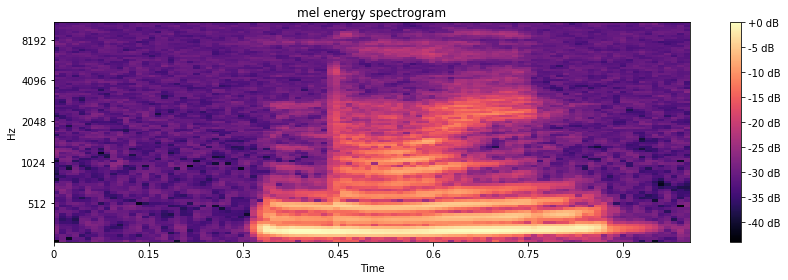

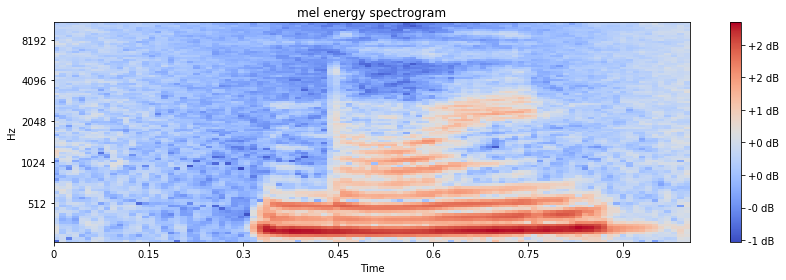

In [20]:
idx += 1
rate, samples = wavfile.read(df['test'].iloc[idx].file)
log_S, _ = mel_spec(samples, rate)
ipd.display(ipd.Audio(samples, rate=rate, autoplay=True))
print(idx, np.mean(log_S), np.std(log_S))
plot_spec(log_S, rate)
plot_spec(ms['test'][idx], rate)
ms['test'][idx]

In [ ]:
log_S.dtype

Let's take a look at the shape of the test samples. They are all 16k samples at a rate of 16k samples per second, so no processing needed.

In [ ]:
test_list = []
for i, r in df['test'].iterrows():
    rate, samples = wavfile.read(r.file)
    test_list.append((rate, len(samples)))
df_tl = pd.DataFrame.from_records(test_list)
df_tl.columns = ['rate', 'n_sampl']
df_tl.groupby(['rate', 'n_sampl']).count()

In [ ]:
samples.dtype

Let's take a look at the shape of the training samples. It looks like everything has a rate of 16k per second, but there are 70 different lengths. I'm going to pad the wavs at the end to get to a fixed length so that all of the mel spectrogram elements are of the same duration.

In [ ]:
train_all_list = []
for i, r in df['train_all'].iterrows():
    rate, samples = wavfile.read(r.file)
    train_all_list.append((rate, len(samples)))
df_trall = pd.DataFrame.from_records(train_all_list)
df_trall.columns = ['rate', 'n_sampl']
df_trall.groupby(['rate', 'n_sampl']).count()

In [107]:
class_names = ds['train'].classes
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=10, hide_pbars=True):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    phases = ['train', 'val']
    
    # set up tensor for storing prediction outputs from best epoch
    columns = list(range(len(class_names))) + ['idx', 'pred', 'label']
    preds_best = torch.FloatTensor()
    
    # set up tensor for storing training and test losses
    mbs_train = math.ceil(len(ds['train'])/bs)
    loss_history = {x: np.zeros(num_epochs*mbs_train) for x in phases}
    
    if use_gpu:
        preds_best.cuda()
    
    for epoch in tnrange(num_epochs, desc='epochs:', disable=hide_pbars):
        if not(hide_pbars):
            print('-'*10)
            print('epoch {}/{}:'.format(epoch + 1, num_epochs))
        
        for phase in phases:
            if phase == 'train':
                model.train(True)
                scheduler.step()
            else:
                model.train(False)
                
                # set up tensor for storing prediction outputs from batch
                preds_e = torch.zeros(len(ds[phase]), len(columns))
                if use_gpu:
                    preds_e = preds_e.cuda()

            running_loss = 0.0
            running_corrects = 0
            running_m = 0

            print(len(dl[phase]))
            for b, data in enumerate(tqdm_notebook(
                dl[phase], desc=phase+":",leave=False, disable=hide_pbars)):
                inputs, labels, idxs = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    idxs = idxs.cuda()
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # update prediction outputs
                running_m += len(idxs)
                if phase != 'train':
                    preds_e_idx = slice(running_m-len(preds), running_m)
                    preds_e[preds_e_idx,:len(class_names)] = outputs.data
                    for t, t1d in enumerate((idxs, preds, labels.data)):
                        preds_e[preds_e_idx,len(class_names) + t] = t1d

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    lh_idx = epoch * mbs_train  + b
                    loss_history[phase][lh_idx] = running_corrects / running_m
                
            epoch_loss = running_loss / len(ds[phase])
            epoch_acc = running_corrects / len(ds[phase])
            
            if not(hide_pbars):
                print('{:>7}--> loss: {:6.4f} acc: {:6.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase != 'train':
                loss_history[phase][(epoch + 1) * mbs_train - 1] = epoch_acc
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    preds_best = preds_e
                
    time_elapsed = time.time() - since
    print('-'*10)
    print('training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('best test acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.cuda.empty_cache()
    
    # create dataframe of prediction outputs with probabilites
    e = torch.exp(preds_best[:, :len(class_names)]) 
    preds_best[:, :len(class_names)] = e / torch.sum(e, 1).view(len(ds['test']), 1)
    
    if use_gpu:
        preds_best = preds_best.cpu()
        
    df_preds = pd.DataFrame(preds_best.numpy(), columns=columns).set_index('idx')
    df_preds.index = df_preds.index.astype(int)
    for col in ['pred', 'label']:
        df_preds[col] = df_preds[col].astype(int)
        df_preds['{}_cl'.format(col)] = df_preds[col].apply(lambda x: class_names[int(x)])
    df_preds['incorrect'] = df_preds.label != df_preds.pred
    
    df_lh = pd.DataFrame(loss_history)
    df_lh.test[df_lh.test == 0] = None
    
    return model, df_preds, df_lh

In [22]:
def convdim(n, p, f, s):
    return (n + 2 * p - f) / s + 1

def pooldim(n, f, s):
    return (n - f) / s + 1


In [ ]:
convdim

In [26]:
convdim(40, 0, 15, 1) * convdim(32, 0, 8, 1) * 64

26624.0

In [80]:
c1d = convdim(100, 7, 15, 1)
print(c1d)
p1 = pooldim(c1d, 5, 1)
print(p1)
c2d = convdim(p1, 7, 15, 1)
print(c2d)
print(c2d**2*64)

100.0
96.0
96.0
589824.0


In [88]:
n = 64
c1d = convdim(n, 7, 15, 1)
p1 = pooldim(c1d, 5, 1)
c2d = convdim(p1, 0, 15, 1)

class Cnn(nn.Module):
    def __init__(self, in_shape=(1, 100, 100), num_classes=len(ds['train'].classes)):
        super(Cnn, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1,  n, kernel_size=15, stride=1, padding=7)
        self.conv2 = nn.Conv2d(n, n, kernel_size=15, stride=1, padding=7)
        self.fc = nn.Linear(int(c2d**2*n), num_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x,inplace=True)
        x = F.max_pool2d(x,kernel_size=(17),stride=(1,1))

        x = self.conv2(x)
        x = F.relu(x,inplace=True)
        x = x.view(x.size(0), -1)

        #x = F.dropout(x,p=0.5,training=self.training)
        x = self.fc(x)

        return x

In [91]:
model = Cnn()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_gpu:
    model = model.cuda()

In [123]:
len(df['val'])

11474

In [118]:
next(iter(dl['train']))

50033
11969
74331
7606
143347
19765
88219
78970
116976
89870
69249
68695
5104
30589
40857


KeyError: 'Traceback (most recent call last):\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/caleb/speech/audio_datasets.py", line 105, in __getitem__\n    label = self.labels[idx]\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/pandas/core/series.py", line 601, in __getitem__\n    result = self.index.get_value(self, key)\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2477, in get_value\n    tz=getattr(series.dtype, \'tz\', None))\n  File "pandas/_libs/index.pyx", line 98, in pandas._libs.index.IndexEngine.get_value\n  File "pandas/_libs/index.pyx", line 106, in pandas._libs.index.IndexEngine.get_value\n  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc\n  File "pandas/_libs/hashtable_class_helper.pxi", line 759, in pandas._libs.hashtable.Int64HashTable.get_item\n  File "pandas/_libs/hashtable_class_helper.pxi", line 765, in pandas._libs.hashtable.Int64HashTable.get_item\nKeyError: 143347\n'

65556
102040
150061


In [108]:
model, df_preds, loss_history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=1, hide_pbars=False)
torch.save(model, 'model')`

HBox(children=(IntProgress(value=0, description='epochs:', max=1), HTML(value='')))

----------
epoch 1/1:
2478


HBox(children=(IntProgress(value=0, description='train:', max=2478), HTML(value='')))

KeyError: 'Traceback (most recent call last):\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "/home/caleb/speech/audio_datasets.py", line 104, in __getitem__\n    label = self.labels[idx]\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/pandas/core/series.py", line 601, in __getitem__\n    result = self.index.get_value(self, key)\n  File "/home/caleb/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2477, in get_value\n    tz=getattr(series.dtype, \'tz\', None))\n  File "pandas/_libs/index.pyx", line 98, in pandas._libs.index.IndexEngine.get_value\n  File "pandas/_libs/index.pyx", line 106, in pandas._libs.index.IndexEngine.get_value\n  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc\n  File "pandas/_libs/hashtable_class_helper.pxi", line 759, in pandas._libs.hashtable.Int64HashTable.get_item\n  File "pandas/_libs/hashtable_class_helper.pxi", line 765, in pandas._libs.hashtable.Int64HashTable.get_item\nKeyError: 125250\n'

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/caleb/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/caleb/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/caleb/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

